In [39]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import Colormap, ListedColormap
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import seaborn as sns
import time
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

##Часть 1

In [40]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [41]:
data = pd.read_csv('/content/gdrive/My Drive/HW1_var_10.csv', delimiter=';')

In [5]:
data.head(10)

,Номер варианта,ID,INCOME_BASE_TYPE,CREDIT_PURPOSE,INSURANCE_FLAG,DTI,SEX,FULL_AGE_CHILD_NUMBER,DEPENDANT_NUMBER,EDUCATION,EMPL_TYPE,EMPL_SIZE,BANKACCOUNT_FLAG,Period_at_work,age,EMPL_PROPERTY,EMPL_FORM,FAMILY_STATUS,max90days,max60days,max30days,max21days,max14days,avg_num_delay,if_zalog,num_AccountActive180,num_AccountActive90,num_AccountActive60,Active_to_All_prc,numAccountActiveAll,numAccountClosed,sum_of_paym_months,all_credits,Active_not_cc,own_closed,min_MnthAfterLoan,max_MnthAfterLoan,dlq_exist,thirty_in_a_year,sixty_in_a_year,ninety_in_a_year,thirty_vintage,sixty_vintage,ninety_vintage
0,10,1000010,2НДФЛ,Покупка автомобиля,1,0.39,мужской,0,0,среднее-специальное,рабочий,< 50,0.0,161.0,55.0,Строительство,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10,1000030,Поступление зарплаты на счет,Покупка автомобиля,1,0.39,женский,1,0,Высшее/Второе высшее/Ученая степень,специалист,>250,0.0,6.0,29.0,Другое,ООО,женат / замужем,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10,1000050,2НДФЛ,Ремонт,1,0.31,женский,0,0,незаконченное высшее,специалист,< 50,3.0,18.0,24.0,Другое,Иная форма,повторный брак,6.0,5.0,5.0,5.0,5.0,0.000000,0.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,1.0,1.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10,1000070,2НДФЛ,Покупка земли,1,NaN,женский,1,0,второе высшее,другое,NaN,1.0,74.0,39.0,Финансы,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10,1000090,2НДФЛ,Ремонт,0,0.47,женский,0,0,высшее,торговый представитель,>250,0.0,10.0,38.0,Наука,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,10,1000110,2НДФЛ,Ремонт,1,0.59,мужской,2,0,Высшее/Второе высшее/Ученая степень,менеджер среднего звена,>=50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,10,1000130,2НДФЛ,Ремонт,0,0.52,мужской,0,0,Высшее/Второе высшее/Ученая степень,специалист,>=50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,10,1000150,Свободная форма с печатью работодателя,Ремонт,0,0.47,мужской,0,0,Высшее/Второе высшее/Ученая степень,вспомогательный персонал,>250,0.0,29.0,32.0,Торговля,ООО,женат / замужем,3.0,2.0,1.0,1.0,1.0,0.064748,0.0,0.0,0.0,0.0,0.3,3.0,7.0,130.0,10.0,1.0,1.0,9.0,86.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
8,10,1000170,Поступление зарплаты на счет,Покупка автомобиля,1,0.49,мужской,1,0,среднее-специальное,рабочий,>250,0.0,15.0,27.0,Производство,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,1000190,2НДФЛ,Покупка автомобиля,1,0.43,женский,2,0,среднее,вспомогательный персонал,>250,3.0,16.0,40.0,Торговля,ООО,женат / замужем,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Для начала удалим из данных номер варианта, он нам точно дальше не понадобится.

In [42]:
data = data.drop(columns=['Номер варианта'])

Теперь поделим признаки на числовые и категориальные в соответсвии с тем, за что они отвечают.

In [43]:
all_features = data.columns
numeric_features = ['DTI', 'FULL_AGE_CHILD_NUMBER', 'DEPENDANT_NUMBER',
                    'Period_at_work', 'age', 'max90days', 'max60days', 'max30days', 'max21days',
                    'max14days', 'avg_num_delay', 'num_AccountActive180', 'num_AccountActive90',
                    'num_AccountActive60', 'Active_to_All_prc', 'numAccountActiveAll', 
                    'numAccountClosed', 'sum_of_paym_months', 'all_credits', 'Active_not_cc',
                    'own_closed', 'min_MnthAfterLoan', 'max_MnthAfterLoan', ]
cat_features = ['INCOME_BASE_TYPE', 'CREDIT_PURPOSE', 'INSURANCE_FLAG', 'SEX', 'EDUCATION', 
                'EMPL_TYPE', 'EMPL_SIZE', 'BANKACCOUNT_FLAG', 'EMPL_PROPERTY', 'EMPL_FORM', 'FAMILY_STATUS',
                'if_zalog', 'dlq_exist', 'thirty_in_a_year', 'sixty_in_a_year', 'ninety_in_a_year',
                'thirty_vintage', 'sixty_vintage', 'ninety_vintage']

Признак "ID" никакой пользы для дальнейших вычислений не имеет, так как его значение индивидуально для каждого пользователя. Так что не будем включать его ни в числовые, ни в категориальные признаки.

Подготовим макет для двух таблиц. Первая, res_all, будет содержать в себе данные анализа всех признаков, а вторая, res_num, те статистики, которые можно рассчитать только для числовых признаков.

In [8]:
res_all = pd.DataFrame(index=['Количество уникальных значений', 'Количество пустых значений', 
                              'Количество нулевых значений', 'Доля уникальных значений от общего количество (%)',
                              'Доля пустых значений от общего количества (%)', 'Доля нулевых значений от общего количества (%)',
                              'Тип признака'], columns=all_features)

In [9]:
res_num = pd.DataFrame(index=['Среднее значение', 'Медиана', 'Стандартное отклонение', 'Минимальное значение', 
                              'Максимальное значение'], columns=numeric_features)

Теперь заполним обе таблички.

In [10]:
for cat in all_features:
    res_all.loc['Количество уникальных значений', cat] = data[cat].nunique()
    res_all.loc['Количество пустых значений', cat] = data[cat].isnull().sum()
    res_all.loc['Количество нулевых значений', cat] = data[data[cat] == 0].shape[0]
    res_all.loc['Доля уникальных значений от общего количество (%)', cat] = res_all.loc['Количество уникальных значений', cat] / data[cat].shape[0] * 100
    res_all.loc['Доля пустых значений от общего количества (%)', cat] = res_all.loc['Количество пустых значений', cat] / data[cat].shape[0] * 100 
    res_all.loc['Доля нулевых значений от общего количества (%)', cat] = res_all.loc['Количество нулевых значений', cat] / data[cat].shape[0] * 100

for cat in numeric_features:
    res_num.loc['Среднее значение', cat] = data[cat].mean()
    res_num.loc['Медиана', cat] = data[cat].median()
    res_num.loc['Стандартное отклонение', cat] = np.std(data[cat])
    res_num.loc['Минимальное значение', cat] = np.min(data[cat])
    res_num.loc['Максимальное значение', cat] = np.max(data[cat])
    res_all.loc['Тип признака', cat] = 'Числовой'

for cat in cat_features:
    res_all.loc['Тип признака', cat] = 'Категориальный'

Таким образом получим следующие результаты.

In [11]:
res_all

,ID,INCOME_BASE_TYPE,CREDIT_PURPOSE,INSURANCE_FLAG,DTI,SEX,FULL_AGE_CHILD_NUMBER,DEPENDANT_NUMBER,EDUCATION,EMPL_TYPE,EMPL_SIZE,BANKACCOUNT_FLAG,Period_at_work,age,EMPL_PROPERTY,EMPL_FORM,FAMILY_STATUS,max90days,max60days,max30days,max21days,max14days,avg_num_delay,if_zalog,num_AccountActive180,num_AccountActive90,num_AccountActive60,Active_to_All_prc,numAccountActiveAll,numAccountClosed,sum_of_paym_months,all_credits,Active_not_cc,own_closed,min_MnthAfterLoan,max_MnthAfterLoan,dlq_exist,thirty_in_a_year,sixty_in_a_year,ninety_in_a_year,thirty_vintage,sixty_vintage,ninety_vintage
Количество уникальных значений,10243,4,10,2,60,2,7,4,9,9,8,5,362,39,12,6,6,21,18,16,14,12,1126,2,5,4,4,91,14,24,325,29,8,8,95,132,2,2,2,2,2,2,2
Количество пустых значений,0,80,0,0,143,0,0,0,0,14,142,2304,2306,2304,2304,6360,6360,6414,6414,6414,6414,6414,6675,6663,6663,6663,6663,6663,6663,6663,6663,6663,6663,6663,6663,6663,6663,6663,6663,6663,6663,6663,6663
Количество нулевых значений,0,0,0,3980,0,0,6089,10198,0,0,0,6256,0,0,0,0,0,1004,1506,1925,2273,2491,1484,2360,2534,3052,3249,453,433,425,13,0,1178,2062,144,11,1496,3014,3272,3349,3464,3534,3531
Доля уникальных значений от общего количество (%),100,0.0390511,0.0976276,0.0195255,0.585766,0.0195255,0.0683394,0.0390511,0.0878649,0.0878649,0.0781021,0.0488138,3.53412,0.380748,0.117153,0.0585766,0.0585766,0.205018,0.17573,0.156204,0.136679,0.117153,10.9929,0.0195255,0.0488138,0.0390511,0.0390511,0.888412,0.136679,0.234306,3.1729,0.28312,0.0781021,0.0781021,0.927463,1.28868,0.0195255,0.0195255,0.0195255,0.0195255,0.0195255,0.0195255,0.0195255
Доля пустых значений от общего количества (%),0,0.781021,0,0,1.39608,0,0,0,0,0.136679,1.38631,22.4934,22.5129,22.4934,22.4934,62.0912,62.0912,62.6184,62.6184,62.6184,62.6184,62.6184,65.1665,65.0493,65.0493,65.0493,65.0493,65.0493,65.0493,65.0493,65.0493,65.0493,65.0493,65.0493,65.0493,65.0493,65.0493,65.0493,65.0493,65.0493,65.0493,65.0493,65.0493
Доля нулевых значений от общего количества (%),0,0,0,38.8558,0,0,59.4455,99.5607,0,0,0,61.0759,0,0,0,0,0,9.80182,14.7027,18.7933,22.1908,24.319,14.4879,23.0401,24.7388,29.796,31.7192,4.42253,4.22728,4.14918,0.126916,0,11.5005,20.1308,1.40584,0.10739,14.6051,29.425,31.9438,32.6955,33.8182,34.5016,34.4723
Тип признака,NaN,Категориальный,Категориальный,Категориальный,Числовой,Категориальный,Числовой,Числовой,Категориальный,Категориальный,Категориальный,Категориальный,Числовой,Числовой,Категориальный,Категориальный,Категориальный,Числовой,Числовой,Числовой,Числовой,Числовой,Числовой,Категориальный,Числовой,Числовой,Числовой,Числовой,Числовой,Числовой,Числовой,Числовой,Числовой,Числовой,Числовой,Числовой,Категориальный,Категориальный,Категориальный,Категориальный,Категориальный,Категориальный,Категориальный


In [12]:
res_num

,DTI,FULL_AGE_CHILD_NUMBER,DEPENDANT_NUMBER,Period_at_work,age,max90days,max60days,max30days,max21days,max14days,avg_num_delay,num_AccountActive180,num_AccountActive90,num_AccountActive60,Active_to_All_prc,numAccountActiveAll,numAccountClosed,sum_of_paym_months,all_credits,Active_not_cc,own_closed,min_MnthAfterLoan,max_MnthAfterLoan
Среднее значение,0.384682,0.556282,0.00576003,66.5444,36.2213,1.62758,1.16009,0.868634,0.65474,0.534343,0.0625163,0.382123,0.173464,0.104469,0.427045,2.22849,3.58603,82.705,5.8148,1.10475,0.740503,13.7598,61.6682
Медиана,0.4,0,0,46,34,1,1,0,0,0,0.0151515,0,0,0,0.4,2,3,65,5,1,0,9,67
Стандартное отклонение,0.138705,0.766647,0.0930359,66.4585,8.66036,1.94538,1.61046,1.39571,1.1908,1.05636,0.116305,0.670874,0.447613,0.345331,0.291305,1.66471,3.21269,71.1493,4.075,1.07039,1.09186,15.1431,30.1486
Минимальное значение,0.01,0,0,4,23,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,-1,-1
Максимальное значение,0.68,6,3,521,61,29,29,29,29,27,1,4,3,3,1,13,28,584,34,7,7,171,171


Теперь исследуем, как признаки между собой коррелируют. Отдельно для числовых и категориальных признаков.

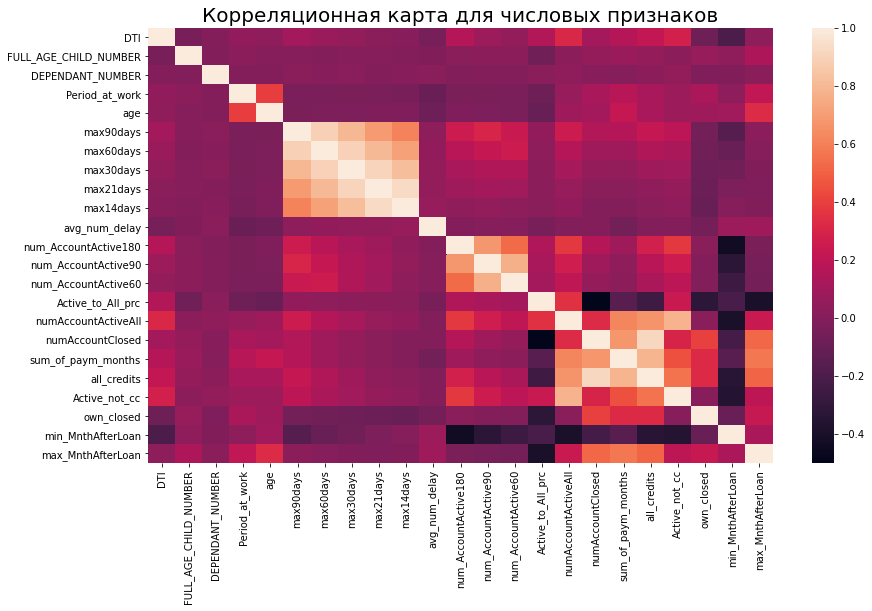

In [13]:
plt.figure(figsize=(14, 8))

plt.title('Корреляционная карта для числовых признаков', fontsize=20)
corr = data[numeric_features].corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)
plt.show()

Как можно заметить, корреляция между большинством числовых признаков довольно низкая. Высокая корреляция наблюдается только между признаками, зависящими друг от друга по очевидным причинам (max90days, max60days, max30days, max21days, max14days	 и т.д.).

Таким образом можно сделать вывод, что данные не имеют явной (а уж тем более линейной) зависимости, а значит анализировать их придется чем-то более сложным, чем регрессионные методы.

Теперь рассмотрим такую же корреляционную карту для категориальных призаков. 

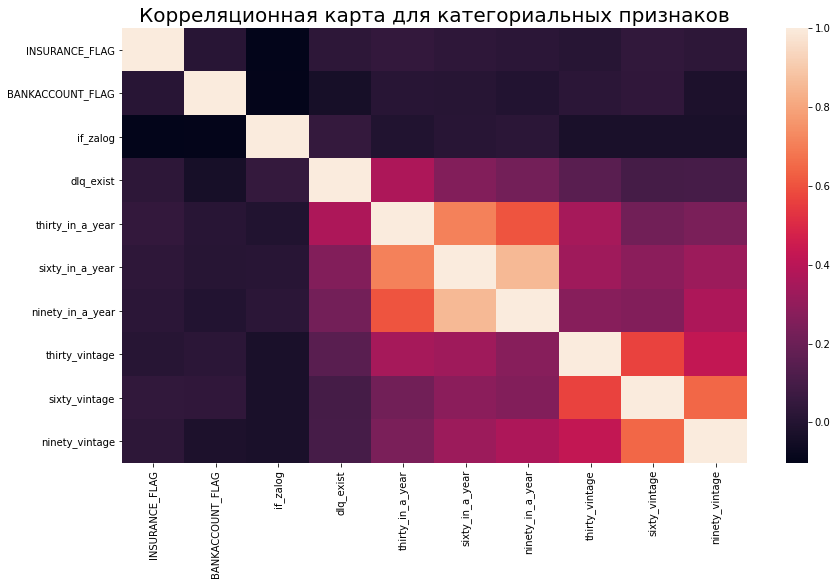

In [14]:
plt.figure(figsize=(14, 8))

plt.title('Корреляционная карта для категориальных признаков', fontsize=20)
corr = data[cat_features].corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)
plt.show()

Можем наблюдать по сути то же самое. Большая корреляция имеется только между очевидно созависимыми признаками (thirty_in_a_year, sixty_in_a_year, ninety_in_a_year и thirty_vintage, sixty_vintage, ninety_vintage).

Теперь для того, чтобы нормально посмотреть на распределение числовых и категориальных признаков сделаем некоторую стандартную предобработку данных. 

Проведем проверку данных на полноту. Для этого для начала посмотрим на количество пропусков в данных каждого пользователя.

In [15]:
emp_count = data.isna().sum(axis=1)

In [16]:
emp_count

0        28
1        21
2         0
3        30
4        28
         ..
10238    32
10239     0
10240     0
10241     0
10242    32
Length: 10243, dtype: int64

In [17]:
emp_count[emp_count > 25].shape[0]

6410

Как можно видеть, у большей части людей больше половины пропусков в данных (всего у нас 43 признака), что, конечно, не есть хорошо. Так как количество пустых значений настолько велико, то можем сделать вывод, что удялять все данные с большим количеством пропусков будет некорректно. Значит просто заменим пропуски в этих данных необходимым образом, так, чтобы в дальнейшем эти изменения не повлияли на результаты анализа (как именно - будет описано далее).

Проверка данных на пропущенные и нулевые поля была проведена ранее. По ее результатам, пустые и нулевые значения имеются в следующих признаках:

In [18]:
print('Пропушенные значения имеются у следующих признаков:')
for cat in res_all.columns:
    if (res_all.loc['Количество пустых значений', cat] > 0):
        print(cat)

print()
print('Нулевые значения имеются у следующих признаков:')
for cat in res_all.columns:
    if (res_all.loc['Количество нулевых значений', cat] > 0):
        print(cat)

Пропушенные значения имеются у следующих признаков:
INCOME_BASE_TYPE
DTI
EMPL_TYPE
EMPL_SIZE
BANKACCOUNT_FLAG
Period_at_work
age
EMPL_PROPERTY
EMPL_FORM
FAMILY_STATUS
max90days
max60days
max30days
max21days
max14days
avg_num_delay
if_zalog
num_AccountActive180
num_AccountActive90
num_AccountActive60
Active_to_All_prc
numAccountActiveAll
numAccountClosed
sum_of_paym_months
all_credits
Active_not_cc
own_closed
min_MnthAfterLoan
max_MnthAfterLoan
dlq_exist
thirty_in_a_year
sixty_in_a_year
ninety_in_a_year
thirty_vintage
sixty_vintage
ninety_vintage

Нулевые значения имеются у следующих признаков:
INSURANCE_FLAG
FULL_AGE_CHILD_NUMBER
DEPENDANT_NUMBER
BANKACCOUNT_FLAG
max90days
max60days
max30days
max21days
max14days
avg_num_delay
if_zalog
num_AccountActive180
num_AccountActive90
num_AccountActive60
Active_to_All_prc
numAccountActiveAll
numAccountClosed
sum_of_paym_months
Active_not_cc
own_closed
min_MnthAfterLoan
max_MnthAfterLoan
dlq_exist
thirty_in_a_year
sixty_in_a_year
ninety_in_a_year

Теперь выполним проверку данных на наличие некорректных знаков

In [19]:
for cat in all_features:
    print('Уникальные значения признака', cat)
    print(data[cat].unique())

Уникальные значения признака ID
[1000010 1000030 1000050 ... 1204810 1204830 1204850]
Уникальные значения признака INCOME_BASE_TYPE
['2НДФЛ' 'Поступление зарплаты на счет'
 'Свободная форма с печатью работодателя'
 'Форма банка (без печати работодателя)' nan]
Уникальные значения признака CREDIT_PURPOSE
['Покупка автомобиля' 'Ремонт' 'Покупка земли'
 'Покупка недвижимости/ строительство' 'Другое' 'Покупка мебели'
 'Обучение' 'Отпуск' 'Лечение' 'Покупка бытовой техники']
Уникальные значения признака INSURANCE_FLAG
[1 0]
Уникальные значения признака DTI
[0.39 0.31  nan 0.47 0.59 0.52 0.49 0.43 0.38 0.45 0.25 0.17 0.36 0.23
 0.46 0.48 0.22 0.29 0.5  0.3  0.32 0.27 0.21 0.58 0.14 0.28 0.18 0.4
 0.11 0.35 0.33 0.2  0.37 0.44 0.55 0.34 0.41 0.57 0.51 0.42 0.26 0.56
 0.12 0.53 0.13 0.08 0.54 0.16 0.1  0.06 0.15 0.09 0.19 0.03 0.24 0.04
 0.07 0.01 0.05 0.02 0.68]
Уникальные значения признака SEX
['мужской' 'женский']
Уникальные значения признака FULL_AGE_CHILD_NUMBER
[0 1 2 3 5 4 6]
Уникальные 

Как можно заметить, среди значений признаков EDUCATION, EMPL_SIZE есть * n.a. *., что можно считать за nan и дальше обрабатывать соответсвующе. Также заметим, что у признаков min_MnthAfterLoan	и max_MnthAfterLoan, отвечающих за минимальное кол-во месяцев, которое прошло с момета взятия прошлого кредита и за	кол-во месяцев прошеднее с момента выдачи первого кредита соответственно есть значени -1. Как можно понять, количество месяцев не может быть отрицательным числом. Так что далее обработаем такие данные как пустые ячейки.

 Остальные признаки никаких особенностей во множестве значений не имеют.

Заполним пропуски в данных. Для категориальных признаков значением "нет данных", для числовых средним значением по признаку. Такой метод будет наиболее корректным (если, кончено, не говорить о более сложных методах заполнения пустых ячеек, связанных с их прогнозированием), так как он не сместит в ту или иную сторону распределение данных, значит с ними все еще можно будет корректно работать.

Для начала вспомним про некорректные значения в признаках EDUCATION, EMPL_SIZE, min_MnthAfterLoan и max_MnthAfterLoan. Обработаем их как пропуски.

In [46]:
data.loc[data['EDUCATION'] == '*n.a.*', 'EDUCATION'] = 'нет данных'
data.loc[data['EMPL_SIZE'] == '*n.a.*', 'EMPL_SIZE'] = 'нет данных'
data.loc[data['min_MnthAfterLoan'] == '-1', 'min_MnthAfterLoan'] = data['min_MnthAfterLoan'].mean()
data.loc[data['max_MnthAfterLoan'] == '-1', 'max_MnthAfterLoan'] = data['max_MnthAfterLoan'].mean()

In [47]:
data[cat_features] = data[cat_features].fillna(value='нет данных')

for cat in numeric_features:
    data[cat] = data[cat].fillna(value=data[cat].mean())

Проверим, что все корректно заполнилось.

In [24]:
data.isnull().sum()

ID                       0
INCOME_BASE_TYPE         0
CREDIT_PURPOSE           0
INSURANCE_FLAG           0
DTI                      0
SEX                      0
FULL_AGE_CHILD_NUMBER    0
DEPENDANT_NUMBER         0
EDUCATION                0
EMPL_TYPE                0
EMPL_SIZE                0
BANKACCOUNT_FLAG         0
Period_at_work           0
age                      0
EMPL_PROPERTY            0
EMPL_FORM                0
FAMILY_STATUS            0
max90days                0
max60days                0
max30days                0
max21days                0
max14days                0
avg_num_delay            0
if_zalog                 0
num_AccountActive180     0
num_AccountActive90      0
num_AccountActive60      0
Active_to_All_prc        0
numAccountActiveAll      0
numAccountClosed         0
sum_of_paym_months       0
all_credits              0
Active_not_cc            0
own_closed               0
min_MnthAfterLoan        0
max_MnthAfterLoan        0
dlq_exist                0
t

Отлично, пропусков в данных больше нет!

Теперь посмотрим на распреденение данных в каждой категории.

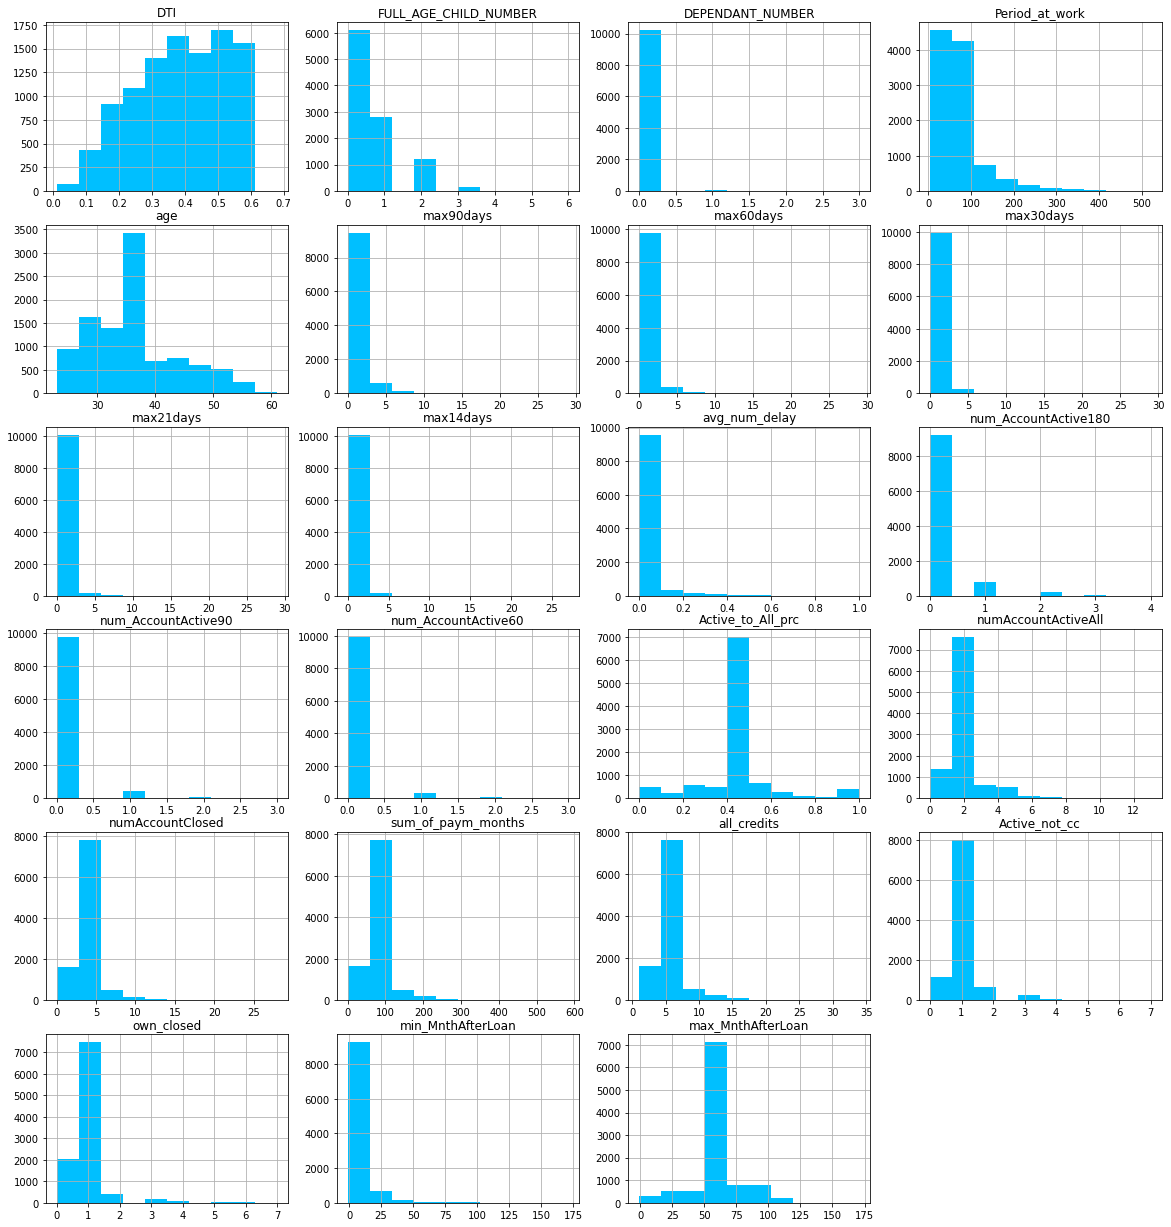

In [25]:
total_axes = len(numeric_features)
plt.figure(figsize=(20, 85))

sp = 1  
for cat in numeric_features:
    plt.subplot(total_axes, 4, sp, title=cat)
    plt.hist(data[cat], color='deepskyblue')
    plt.grid()
    sp += 1


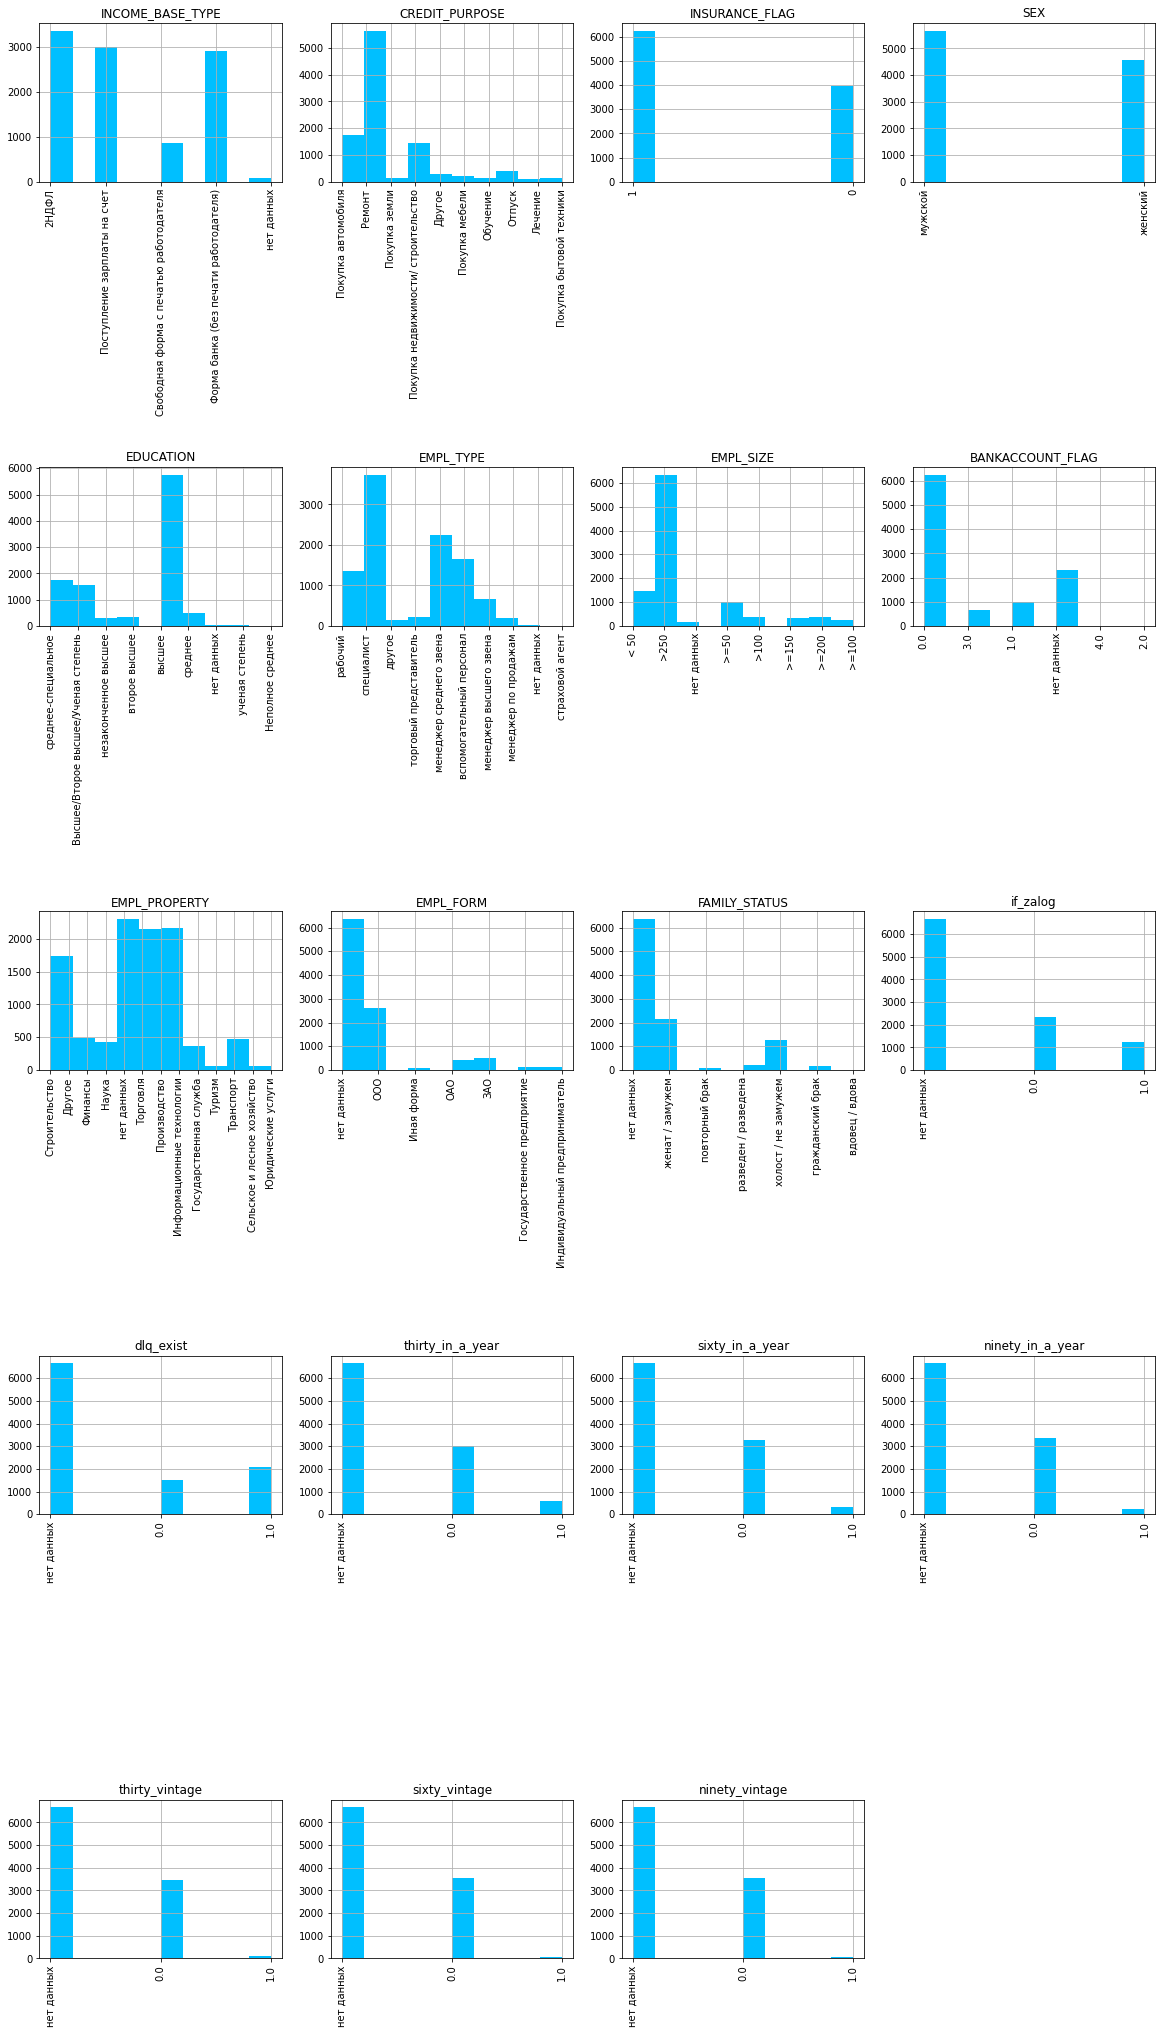

In [37]:
total_axes = len(cat_features)
plt.figure(figsize=(20, 150))
plt.title('График распределения значений категориальныхых признаков', fontsize=20)

sp = 1  
for cat in cat_features:
    plt.subplot(total_axes, 4, sp, title=cat)
    plt.hist(data[cat].astype(str), color='deepskyblue')
    plt.subplots_adjust(hspace=1.8)
    plt.xticks(rotation=90)
    plt.grid()
    sp += 1


Как можно видеть, основной причиной взятия кредита является ремонт, больше в банк обращаются мужчины, чем женщины, а также в основном клиенты имеют высшее образование и доход больше 250 тысяч. Дааные факты помогут нам дальше при анализе (могут помочь).

Также на этих графиках можно явно далюдать нашу проблему с огромным количеством пропусках в данных. 

Теперь переведем категориальные признаки в числовые, используя стандартный способ - One Hot encoding.


In [52]:
enc = OneHotEncoder()
data[cat_features] = data[cat_features].astype(str)
new_cat = enc.fit_transform(data[cat_features])

Таким образом теперь new_cat - матрица с категориальными признаками, закодированными при помощи OHE.

И наконец скачаем полученную табличку для того, чтобы дальше выполнять кластеризацию в системе SAS. Как мне показалось, там больше возможностей для визуализации результатов, так что остановила свой выбор именно на таком варианте работы.

In [38]:
data.to_csv('data_re.tsv', sep=';')
from google.colab import files
files.download("data_re.tsv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Часть 2

Первым методом сегментации, исследуемым мной, будет метод обучения без учителя, а именно k-means. В целом для нашей задачи хорошо подходит подход обучения без учителя как минимум потому, что у нас нет таргета, а использовать в качестве таргета какой-то признак не совсем корректно (далее об этом будет). Также плюсом является то, что результаты очень удобно интерпретировать.

Для кластеризации методом k-means были использованы такие признаки как: age (возраст), period_of_work(время работы в днях) и sum_of_payment_month (сумма ежемесячного платежа).

<img src="https://psv4.userapi.com/c532036/u169642165/docs/d22/9c602efcf4bb/Momentalny_snimok_Klaster__age_1_17_02_2021_v_22_26_23.png?extra=HwfSVRWtFU-O_zJ8CefSJnjdCKRkRzMd-AQd2gpMDKsOByZlRpG78D9xsza0KACbSYB4xfvhCSowluPXoRSIltzL3VVXl-Jo2uEK6PAQpdhE0Sfowem3MLPdzNHVjIS3RsPBlGDFaLY_yekgUqQFUE2SNw">

Теперь рассмотрим по отдельности каждый из 4 получившихся кластеров.

<img src="https://sun9-64.userapi.com/impf/pXmjvcaQiD7FjC_G8Oqq6V37Ucu-k4ujpKX5RQ/zkuW4cuifeU.jpg?size=1513x347&quality=96&proxy=1&sign=f6ebc3e94b07397498f4429764c0583d&type=album">

Представители четвертого кластера имеют большой возраст (в среднем около 48), но при этом относительно маленькое время работы (в среднем 50 дней) и ниже среднего по всем клиентам сумму ежемесячного платежа. В качестве клиентов банка людей данной группы можно интерпретирвоать как людей более старшего возраст, не имеющим большого опыта работы, а следовательно не готовых брать крупные кредиты (или не очень крупные, но с большими ежемесячными выплатами).

<img src="https://sun9-24.userapi.com/impf/bMyvliYZd9ROMLjuYSYWI8DlNYoYpAn-OT59Xw/yw6YrUtyx_Q.jpg?size=1486x301&quality=96&proxy=1&sign=b8b0ce17831363a674a0bec18f4cf405&type=album">

Представители третьего кластера имеют небольшой возраст (в среднем 28 лет), самое маленькое среди всех кластеров время работы (около 30 дней) и самую низкую сумму ежемесячного платежа. В рамках клиентов банка это можно интерпретиовать как группу "молодежи", которые не так давно закончили ВУЗы, не имеет большого опыта работы и претендуют на кредиты небольшой суммы соответственно с небольшими месячными платежами (например, на учебу, технику и т.д.) или более крупыне кредиты, но на большой срок. 

<img src="https://sun9-3.userapi.com/impf/gubtxPYN-worrCDxgBLxUEWLw6-dgcYI_CIsDA/HIUWSHQ29Lg.jpg?size=1500x296&quality=96&proxy=1&sign=2126271cc6aa50eddb1caa6f83a5f8d4&type=album">

Представители второго кластера имеют средний возраст около 36 лет, около 70 дней время работы  и высокие ежемесячные выплаты. Данный сегмент клиентов можно интерпритировать как группу людей среднего возраста, работающих на относительно стабильно работе и нужнающихся в каком-то крупном кредите, например, на жилье или ремонт, готовых взять кредит с большими ежемесячными выплатами на не очень большой срок.

<img src="https://sun9-60.userapi.com/impf/9aqv2b4IO7G55-6gBOITm2oEB6mHDJb5734FDQ/dCIelDaizGI.jpg?size=1490x302&quality=96&proxy=1&sign=0a56bbf7ea34787750a9664f99f43afb&type=album">

Представители первого кластера имеют средний возраст около 45 и наибольший среди всех пользователей банка срок работы (в среднем 220 дней), а также высокие суммы ежемесячных платежей. В целом данные кластер также можно интрпретировать как людей среднего и более старшего возраста, имеющих уже точно стабильный заработок, а значит готовых выплачивать большие ежемесячные суммы (в случае крупных кредитов или не очень, но на маленький срок). Это также могут быть кредиты на жильи, автомобили, ремонт и другие. 

Вторым исследуемым методом сигментации данных стало решающее дерево. Собственно дерево решений как раз таки является методом кластеризации с учителем. В нашем случае это является недостатком и вообще говоря проблемой, так как таргет (то есть прогнозируемая переменная) нам не известен. акже, говоря о недостатках конкретно решающего дерева хочется упомянуть о том, что решающие деревья очень чувствительны к шумам в данных. А также результаты кластеризации более тяжело интерпетирвать. Но плюсом является то, что данные более полные (описаны конкретные значения по каждой категории, а не примерный разброс и т.д.)

Обычно в таком случае поступают следующим образом - в качестве таргета берут признак, распределение данных по значениям которого примерно равномерно (просто для того, чтобы классификатор - то есть непосредственно решающее дерево, не склонялся постоянно в сторону доминирующего класса). Можем посмотреть на графики распределений выше и понять, что у нас признака, полностью подходящего под эти критерии нет, но больше всего подходит INCOME_BASE_TYPE, его и возьмем в качестве таргета. 

В качестве предикторов же рассмотрим такие признаки как: EMPL_SIZE (зарплата), sum_of_paym_month (сумма платежей за месяц), DTI (отношение долгов к доходу), EDICATION (образование), age (возраст). Выбраны они били изначально исходя из логики того, какие признаки могут быть важны при составлении портрета клиента банка, а также по тому, чтобы они были значимыми при прогнозировании решающим деревом. В итоге по значимости вышло следующее:


<img src="https://sun9-8.userapi.com/impf/e3vUUr2es1tdOGLj8FbLVSdEcrmPBWewbRoupQ/hngowdONbgQ.jpg?size=1728x242&quality=96&proxy=1&sign=fa5d32f46af9c473d64860ad88296622&type=album">

<img src="https://sun9-1.userapi.com/impf/_jP3SZ2O5cTCeSd4GhmuIhexCjz-dQLmedeKxA/Fn4RTCAXWz8.jpg?size=1871x588&quality=96&proxy=1&sign=1621b95f03e1b365e4726201dd39ec8d&type=album">

Изначально на дерево решений было наложено ограничение на глубину не больше 6, чтобы результаты можно было нормально проанализировать.

Далее, дабы не описывать группу, буду называть ее по номеру, указанному в таблице выше. Как можно заметить, получилось нексколько очень общих класстеров, так что размерем отдельно только те, которые включают в себя достаточно данных о клиенте. Рассмотрим только кластеры в которых достаточно данных.

Получим следующее:

1) Зароботок от 150 тысяч, сумма платежей в месяц от 0 до 67, отношение долгов к доходу от 0,01 до 0,33 (низкое)

2) Зароботок от 150 тысяч, сумма платежей в месяц от 0 до 67, отношение долгов к доходу больше или равно 0,41

3) Зароботок от 150 тысяч, образование: второе высшее, высшее, незаконченное высшее, нет данных, среднее, or среднее-специальное, возраст от 23 до 25, сумма платежей в месяц больше 67, отношение долгов к доходу от 0,01 до 0,41

4) Зароботок от 150 тысяч, образование: Высшее/Второе высшее/Ученая степень, незаконченное высшее, среднее, or среднее-специальное, отношение долгов к доходу больше или равно 0,41


5) Зароботок от 50 до 150 тысяч, образование: Высшее/Второе высшее/Ученая степень, незаконченное высшее, среднее, or среднее-специальное, отношение долгов к доходу больше или равно 0,41


6) Зароботок от 50 до 150 тысяч, образование: Высшее/Второе высшее/Ученая степень or ученая степень, сумма платежей в месяц больше 120, отношение долгов к доходу больше или равно 0,41


7) Зароботок от 150 тысяч, образование: Высшее/Второе высшее/Ученая степень or ученая степень, сумма платежей в месяц от 67 до 120, отношение долгов к доходу больше или равно 0,41

8) Зароботок от 150 тысяч, возраст больше 36, сумма платежей в месяц больше 67, отношение долгов к доходу от 0,01 до 0,41
 
9) Зароботок от 150 тысяч, возраст от 25 до 36, сумма платежей в месяц больше 67, отношение долгов к доходу от 0,01 до 0,41

10) Зароботок от 150 тысяч, образование: высшее или ученая степень, сумма платежей в месяц от 28 до 67, отношение долгов к доходу больше или равно 0,33

11) Зароботок от 150 тысяч, сумма платежей в месяц от 0 до 28, отношение долгов к доходу больше или равно 0,55 (очень высокое)

12) Зароботок от 150 тысяч, сумма платежей в месяц от 0 до 28, отношение долгов к доходу от 0,33 до 0,55

Как можно заметить, в данном случае кластеры вышли более смешанными, а также некоторые более обобщенными. Как минимум произошло это потому что нами рассмотрено больше признаков, а значит больший шанс, что люди в разных категориях признаков пересекаются.

Если говорить в общем, то оба метода сегментации показали неплохие результаты и могут использоваться при решении подобных задач в реальной жизни. Но всегда нужно пробовать несколько методов, а также аналитически подбирать тот, который лучше подходит под решаемую задачу. 